**Imports**

In [1]:
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from glob import glob
import librosa
import librosa.display
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')

In [2]:
audio_files = os.listdir('/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset')
for files in audio_files:
    print(files)
print(len(audio_files))

Punjabi
Tamil
Hindi
Bengali
Telugu
Kannada
Gujarati
Urdu
Marathi
Malayalam
10


**Visualizing MFCC Spectrograms**

In [3]:
# Function to extract MFCC features
def extract_mfcc(audio_path, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [4]:
# Path to the dataset
audio_dir = '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset'  # Replace with the actual path
mfcc_features = {}
language_samples = {}

# Extract MFCC features for each language
for language in os.listdir(audio_dir):
    language_path = os.path.join(audio_dir, language)
    if os.path.isdir(language_path):
        print(f"Processing {language} audio files...")
        mfcc_list = []
        file_list = []
        audio_files = [f for f in os.listdir(language_path) if f.endswith('.mp3')]
        random.shuffle(audio_files)  # Shuffle the files to ensure randomness
        
        for audio_file in tqdm(audio_files):
            if len(mfcc_list) >= 3: # considering 6000 samples for classifier training
                break
            
            audio_path = os.path.join(language_path, audio_file)
            mfcc = extract_mfcc(audio_path)
            if mfcc is not None and mfcc.size > 0:
                mfcc_list.append(mfcc)
                file_list.append(audio_path)
        
        mfcc_features[language] = mfcc_list
        language_samples[language] = file_list

# Save MFCC features to a file
pd.to_pickle(mfcc_features, 'mfcc_features.pkl')

Processing Punjabi audio files...


  0%|          | 3/26229 [00:18<45:42:37,  6.27s/it] 


Processing Tamil audio files...


  0%|          | 3/24196 [00:00<17:45, 22.70it/s]


Processing Hindi audio files...


  0%|          | 3/25462 [00:00<19:38, 21.60it/s]


Processing Bengali audio files...


  0%|          | 3/27258 [00:00<21:31, 21.10it/s]


Processing Telugu audio files...


  0%|          | 3/23656 [00:00<18:34, 21.23it/s]


Processing Kannada audio files...


  0%|          | 3/22208 [00:00<21:25, 17.28it/s]


Processing Gujarati audio files...


  0%|          | 3/26441 [00:00<21:35, 20.40it/s]


Processing Urdu audio files...


  0%|          | 3/31960 [00:00<24:30, 21.73it/s]


Processing Marathi audio files...


  0%|          | 3/25379 [00:00<19:40, 21.50it/s]


Processing Malayalam audio files...


  0%|          | 3/24044 [00:00<27:20, 14.66it/s]


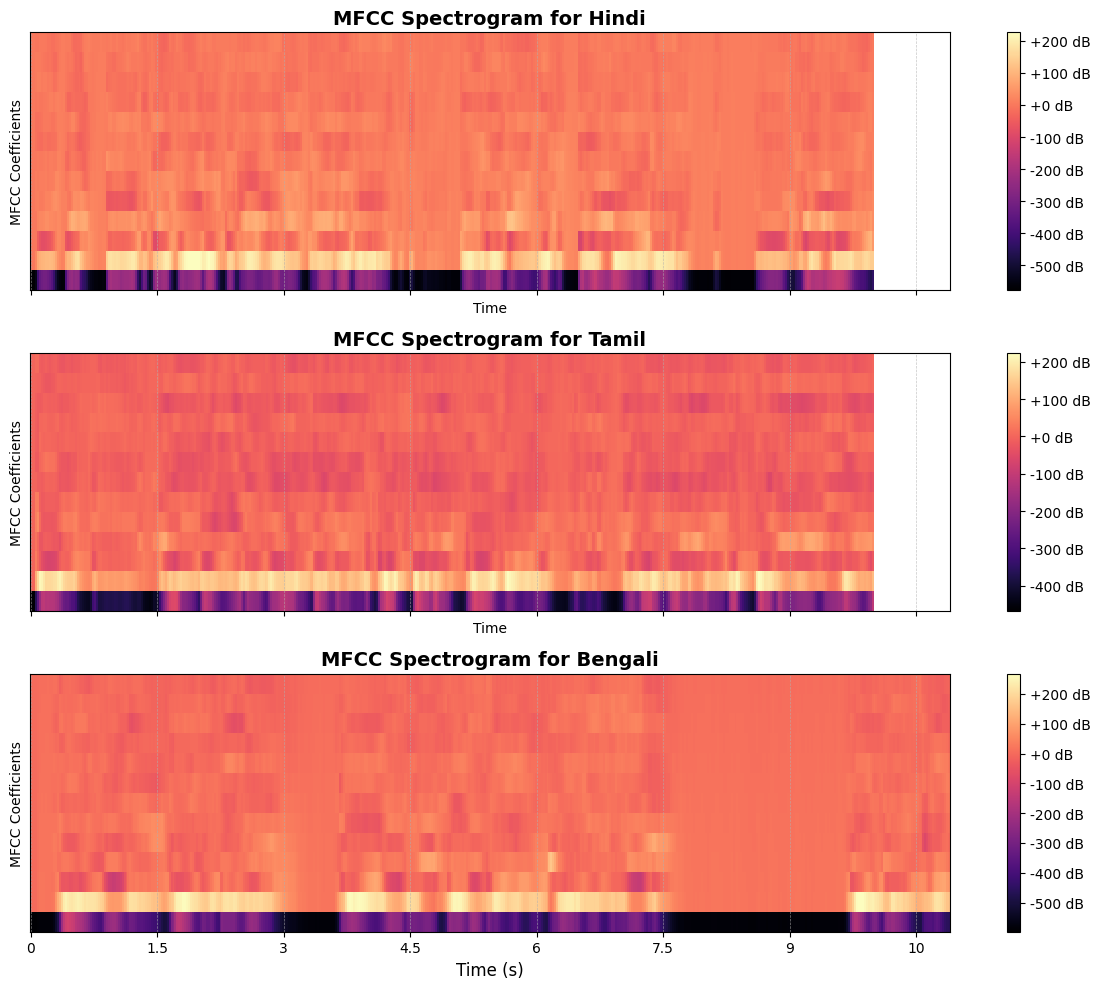

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Select three languages for visualization
selected_languages = ['Hindi', 'Tamil', 'Bengali']  # Replace with your chosen languages

# Create a figure for visualization
fig, axes = plt.subplots(len(selected_languages), 1, figsize=(12, 10), sharex=True)

for i, language in enumerate(selected_languages):
    if language in mfcc_features and len(mfcc_features[language]) > 0:
        # Select a representative sample
        sample_idx = np.random.randint(len(mfcc_features[language]))  # Random sample
        mfcc = mfcc_features[language][sample_idx]
        
        # Plot MFCC spectrogram
        ax = axes[i] if len(selected_languages) > 1 else axes
        img = librosa.display.specshow(mfcc, x_axis='time', cmap='magma', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set_title(f'MFCC Spectrogram for {language}', fontsize=14, fontweight='bold')
        ax.set_ylabel('MFCC Coefficients')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

axes[-1].set_xlabel('Time (s)', fontsize=12)
plt.tight_layout()
plt.savefig('mfcc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


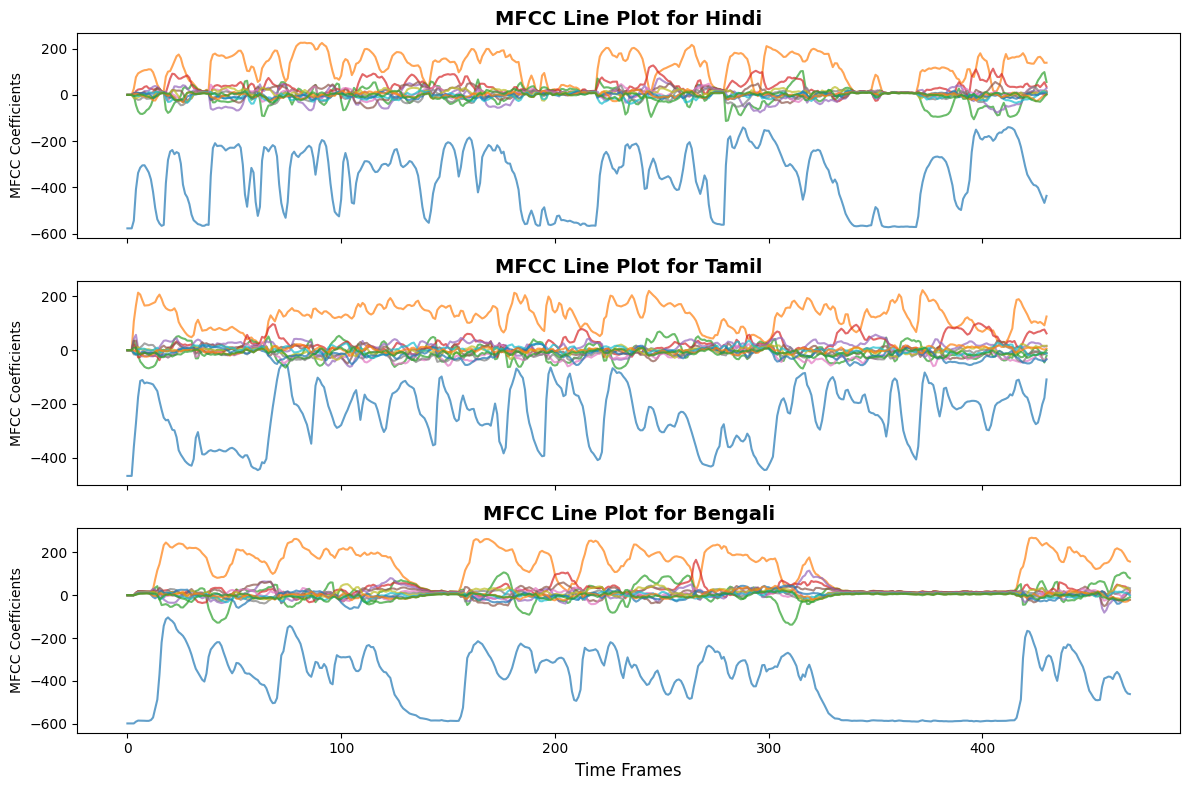

In [7]:
fig, axes = plt.subplots(len(selected_languages), 1, figsize=(12, 8), sharex=True)

for i, language in enumerate(selected_languages):
    if language in mfcc_features and len(mfcc_features[language]) > 0:
        sample_idx = np.random.randint(len(mfcc_features[language]))
        mfcc = mfcc_features[language][sample_idx]

        ax = axes[i] if len(selected_languages) > 1 else axes
        for coeff in mfcc:
            ax.plot(coeff, alpha=0.7)  # Each line represents an MFCC coefficient
        
        ax.set_title(f'MFCC Line Plot for {language}', fontsize=14, fontweight='bold')
        ax.set_ylabel('MFCC Coefficients')

axes[-1].set_xlabel('Time Frames', fontsize=12)
plt.tight_layout()
plt.savefig('mfcc_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()


**Comparative Analysis of MFCC Features**

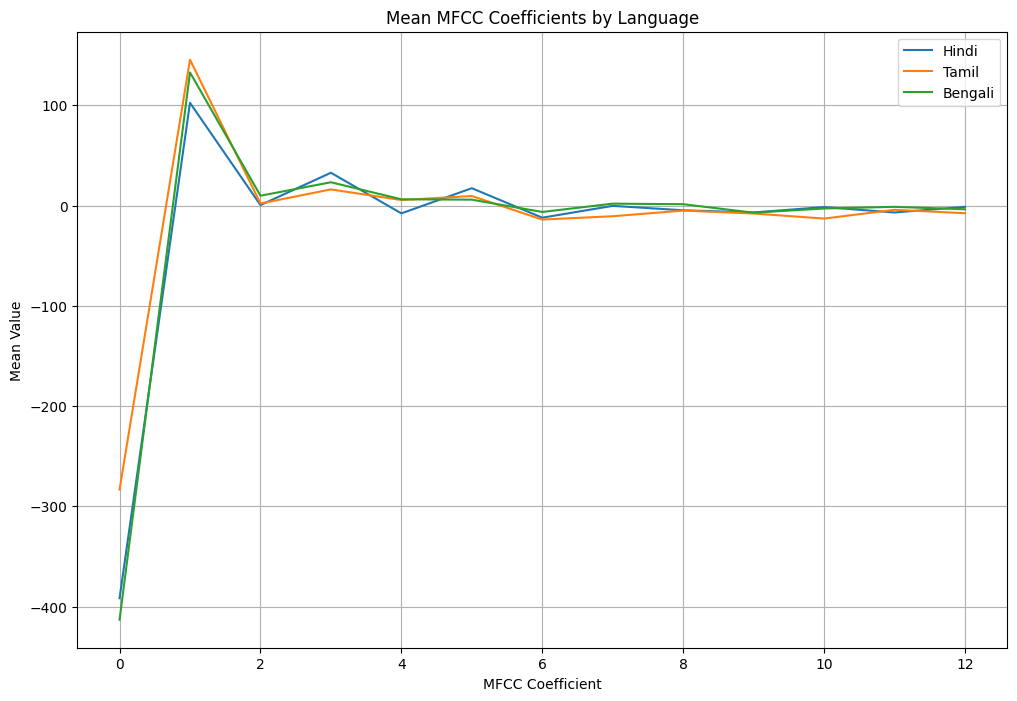

In [11]:
# Statistical analysis of MFCC features
stats = {}

for language in mfcc_features:
    if len(mfcc_features[language]) > 0:
        # Concatenate all MFCCs for this language
        all_mfccs = np.concatenate(mfcc_features[language], axis=1)
        
        # Compute mean and variance across time
        mean_mfcc = np.mean(all_mfccs, axis=1)
        var_mfcc = np.var(all_mfccs, axis=1)
        
        stats[language] = {
            'mean': mean_mfcc,
            'variance': var_mfcc
        }

# Visualize mean MFCC coefficients for each language
plt.figure(figsize=(12, 8))
for language in selected_languages:
    if language in stats:
        plt.plot(stats[language]['mean'], label=language)
plt.title('Mean MFCC Coefficients by Language')
plt.xlabel('MFCC Coefficient')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.savefig('mean_mfcc_comparison.png')
plt.show()


**Task B: Language Classification Using MFCC Features**

In [12]:
len(mfcc_features)

10

In [ ]:
# Preparing data for classification
X = []
y = []

for language in mfcc_features:
    for mfcc in mfcc_features[language]:
        # Compute mean of each coefficient across time to get a fixed-length feature vector
        mfcc_mean = np.mean(mfcc, axis=1)
        X.append(mfcc_mean)
        y.append(language)

X = np.array(X)
y = np.array(y)

In [ ]:


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Train a Random Forest classifier
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

Training Random Forest classifier...

Random Forest Classification Report:
              precision    recall  f1-score   support

     Bengali       0.90      0.95      0.92      1182
    Gujarati       0.40      0.38      0.39      1235
       Hindi       0.96      0.98      0.97      1175
     Kannada       0.97      0.93      0.95      1222
   Malayalam       0.94      0.97      0.96      1193
     Marathi       0.98      0.97      0.97      1243
     Punjabi       0.40      0.41      0.40      1198
       Tamil       0.97      0.97      0.97      1194
      Telugu       0.97      0.96      0.96      1160
        Urdu       0.94      0.93      0.94      1198

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



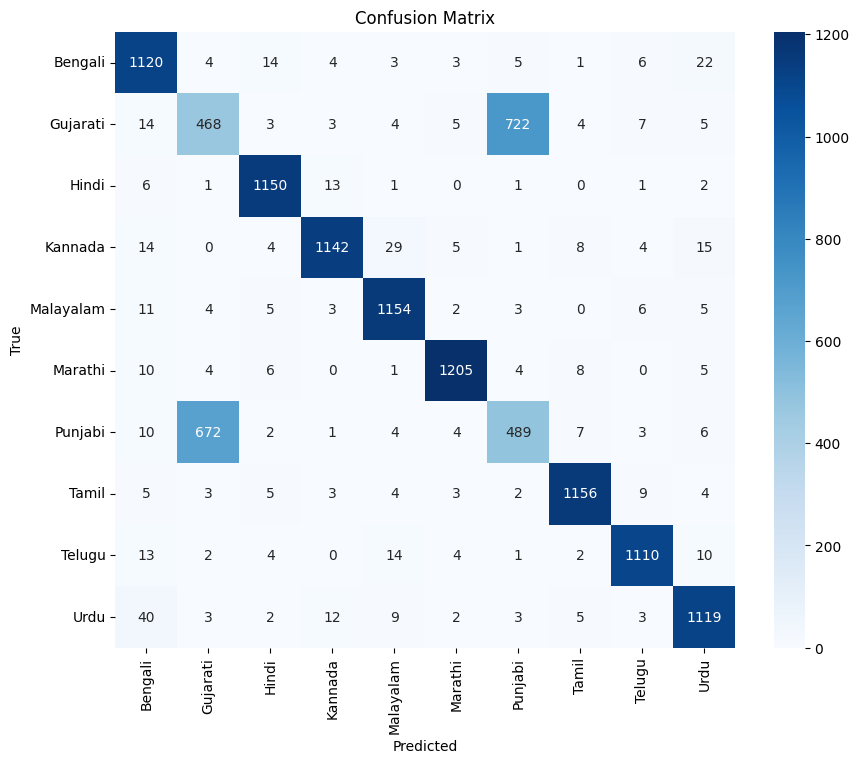


SVM Classification Report:
              precision    recall  f1-score   support

     Bengali       0.92      0.95      0.93      1182
    Gujarati       0.48      0.42      0.45      1235
       Hindi       0.94      0.99      0.97      1175
     Kannada       0.99      0.94      0.96      1222
   Malayalam       0.96      0.96      0.96      1193
     Marathi       0.97      0.97      0.97      1243
     Punjabi       0.48      0.53      0.50      1198
       Tamil       0.98      0.97      0.98      1194
      Telugu       0.95      0.96      0.96      1160
        Urdu       0.94      0.93      0.94      1198

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000


Neural Network Classification Report:
              precision    recall  f1-score   support

     Bengali       0.93      0.94      0.94      1182
    Gujarati       0.47      0.40      0.43      1235
       Hind

In [13]:

# Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)
print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_pred))
